In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d  # Smoothing


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [ ]:
!pip install gdown
!gdown 'https://drive.google.com/uc?id=1A0xoL44Yg68ixd-FuIJn2VC4vdZ6M2gn'
!unzip -q WildRF.zip

Downloading...
From (original): https://drive.google.com/uc?id=1A0xoL44Yg68ixd-FuIJn2VC4vdZ6M2gn
From (redirected): https://drive.google.com/uc?id=1A0xoL44Yg68ixd-FuIJn2VC4vdZ6M2gn&confirm=t&uuid=3202df74-e9fd-4c55-acb1-4105dcd9cbdd
To: /content/WildRF.zip
100% 6.40G/6.40G [01:25<00:00, 75.0MB/s]


In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
def get_req_set(path):
  df = pd.read_csv(path)
  features_df = df['features'].str.strip('[]').str.split(',', expand=True)
  features_df = features_df.astype(float)
  features_df.columns = [f'feature_{i}' for i in range(features_df.shape[1])]
  df_expanded = pd.concat([features_df, df['label']], axis=1)
  X = df_expanded.drop(columns=['label'])
  y = df_expanded['label']
  X_tensor = torch.tensor(X.values, dtype=torch.float32)
  y_tensor = torch.tensor(y.values, dtype=torch.long)
  dataset = TensorDataset(X_tensor, y_tensor)
  print(len(dataset))
  temp_loader = DataLoader(dataset, batch_size=32, shuffle=True)
  return temp_loader

In [ ]:
#JPEGS taken from all folders

In [ ]:
train_loader = get_req_set('/content/train_features.csv')
val_loader_1 = get_req_set('/content/facebook_features.csv')
val_loader_2 = get_req_set('/content/reddit_features.csv')
val_loader_3 = get_req_set('/content/twitter_features.csv')
val_loader_4 = get_req_set('/content/val_features.csv')

2712
320
1500
421
398


In [ ]:
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim, dropout_prob=0.2):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.fc3 = nn.Linear(hidden_dim_2, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [ ]:
# Updated loop with four validation datasets and additional metrics
input_dim = 768      # Number of features in the produced dataset
hidden_dim_1 = 128
hidden_dim_2 = 256
output_dim = 2 # Number of classes -- 2
model = DNN(input_dim, hidden_dim_1, hidden_dim_2, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        #print(outputs)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == batch_y).sum().item()
        total_samples += batch_y.size(0)

    # Calculate train loss and metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_samples * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on train data
    model.eval()
    with torch.no_grad():
        y_true_train = []
        y_pred_train = []
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            y_true_train.extend(batch_y.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

    # Calculate train metrics
    train_precision = precision_score(y_true_train, y_pred_train, average='binary')
    train_recall = recall_score(y_true_train, y_pred_train, average='binary')
    train_f1 = f1_score(y_true_train, y_pred_train, average='binary')

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Train Precision: {train_precision:.2f}, Train Recall: {train_recall:.2f}, Train F1: {train_f1:.2f}")

    # Validation loaders and names
    val_loaders = [val_loader_1, val_loader_2, val_loader_3, val_loader_4]
    val_names = ['Facebook', 'Reddit', 'Twitter', 'Validation']

    # Evaluate on each validation set
    for val_loader, val_name in zip(val_loaders, val_names):
        y_true_val = []
        y_pred_val = []
        val_loss = 0.0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                y_true_val.extend(batch_y.cpu().numpy())
                y_pred_val.extend(predicted.cpu().numpy())

        # Calculate metrics for each validation set
        val_loss /= len(val_loader)
        val_accuracy = accuracy_score(y_true_val, y_pred_val) * 100
        val_precision = precision_score(y_true_val, y_pred_val, average='binary')
        val_recall = recall_score(y_true_val, y_pred_val, average='binary')
        val_f1 = f1_score(y_true_val, y_pred_val, average='binary')

        print(f"{val_name} - "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, "
              f"Val Precision: {val_precision:.2f}, Val Recall: {val_recall:.2f}, Val F1: {val_f1:.2f}")

    print("------------------------------------------------")
torch.save(model.state_dict(), 'model_weights.pth')

Epoch [1/10], Train Loss: 0.4563, Train Accuracy: 78.54%, Train Precision: 0.82, Train Recall: 0.93, Train F1: 0.87
Facebook - Val Loss: 0.4094, Val Accuracy: 81.25%, Val Precision: 0.77, Val Recall: 0.89, Val F1: 0.83
Reddit - Val Loss: 0.3188, Val Accuracy: 86.67%, Val Precision: 0.81, Val Recall: 0.95, Val F1: 0.88
Twitter - Val Loss: 0.3231, Val Accuracy: 85.51%, Val Precision: 0.90, Val Recall: 0.88, Val F1: 0.89
Validation - Val Loss: 0.3219, Val Accuracy: 84.17%, Val Precision: 0.79, Val Recall: 0.93, Val F1: 0.85
------------------------------------------------
Epoch [2/10], Train Loss: 0.2839, Train Accuracy: 88.53%, Train Precision: 0.96, Train Recall: 0.85, Train F1: 0.90
Facebook - Val Loss: 0.4043, Val Accuracy: 81.56%, Val Precision: 0.94, Val Recall: 0.68, Val F1: 0.79
Reddit - Val Loss: 0.2392, Val Accuracy: 90.53%, Val Precision: 0.95, Val Recall: 0.85, Val F1: 0.90
Twitter - Val Loss: 0.4550, Val Accuracy: 80.76%, Val Precision: 0.97, Val Recall: 0.73, Val F1: 0.83
Va

In [ ]:
# Loading Saved DNN Weights

In [ ]:
# CHECKING CALIBRATION FOR VALIDATION DS -- WILDRF

In [ ]:
model = DNN(input_dim, hidden_dim_1, hidden_dim_2, output_dim)  # Replace with your model class
model.load_state_dict(torch.load('model_weights.pth'))  # Load saved weights
model.eval()  # Set the model to evaluation mode

<ipython-input-202-f099e95e57f6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth'))  # Load saved weights


DNN(
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
softmax_probs = []
true_labels = []

In [ ]:
with torch.no_grad():
    for inputs, labels in train_loader: #train
        logits = model(inputs)
        probs = F.softmax(logits, dim=1)
        softmax_probs.append(probs.cpu().numpy())
        true_labels.append(labels.cpu().numpy())
softmax_probs = np.concatenate(softmax_probs, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
def plot_calibration_curve(y_true, y_prob, n_bins=10, label='Uncalibrated'):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=label)
    return prob_true, prob_pred

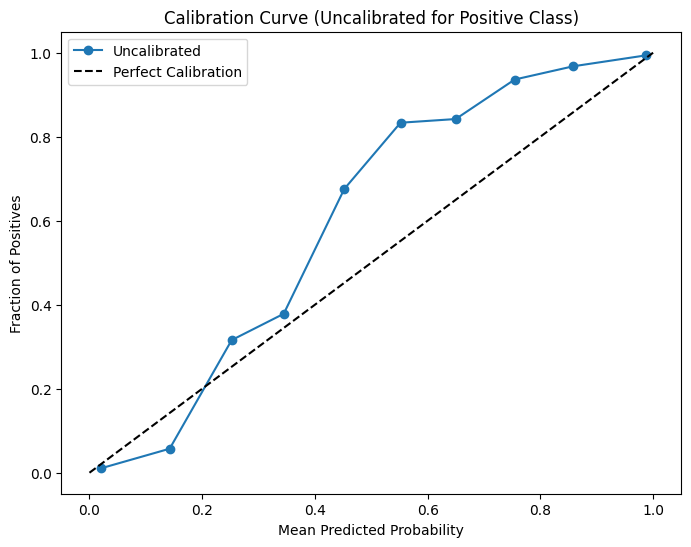

In [ ]:
positive_probs = softmax_probs[:, 1]
positive_labels = (true_labels == 1).astype(int)
plt.figure(figsize=(8, 6))
plot_calibration_curve(positive_labels, positive_probs, label='Uncalibrated')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Uncalibrated for Positive Class)')
plt.legend()
plt.show()

In [ ]:
logits = softmax_probs

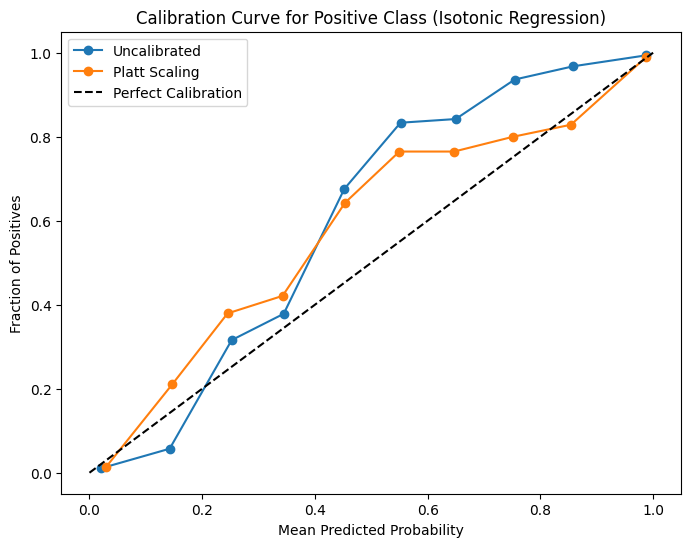

In [ ]:
# Assuming `softmax_probs` are already probabilities in [0, 1] (logits transformed by softmax)
positive_class_idx = 1  # Define the positive class index
positive_probs = softmax_probs[:, positive_class_idx]  # Extract positive class probabilities
positive_labels = (true_labels == positive_class_idx).astype(int)  # Binary labels for the positive class

# Fit PLATT SCALING -- scaled Logistic Regression to logits
log_reg = LogisticRegression()
log_reg.fit(positive_probs.reshape(-1,1), true_labels)  # Fit on positive class probabilities and binary labels

# Predict calibrated probabilities for the positive class
calibrated_probs_iso = log_reg.predict_proba(positive_probs.reshape(-1,1))[:,1]

# Plot Calibration Curve
def plot_calibration_curve(y_true, y_prob, n_bins=10, label=None):
    from sklearn.calibration import calibration_curve
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=label)

plt.figure(figsize=(8, 6))

# Uncalibrated
plot_calibration_curve(true_labels, positive_probs, label='Uncalibrated')

# Calibrated
plot_calibration_curve(true_labels, calibrated_probs_iso, label='Platt Scaling')

# Perfect calibration line
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')

# Plot settings
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve for Positive Class (Isotonic Regression)')
plt.legend()
plt.show()


In [ ]:
# chceking uncalibrated model on VAL
softmax_probs = []
true_labels = []
with torch.no_grad():
    for inputs, labels in val_loader_4: #val
        logits = model(inputs)
        probs = F.softmax(logits, dim=1)
        softmax_probs.append(probs.cpu().numpy())
        true_labels.append(labels.cpu().numpy())
softmax_probs = np.concatenate(softmax_probs, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
logits = softmax_probs

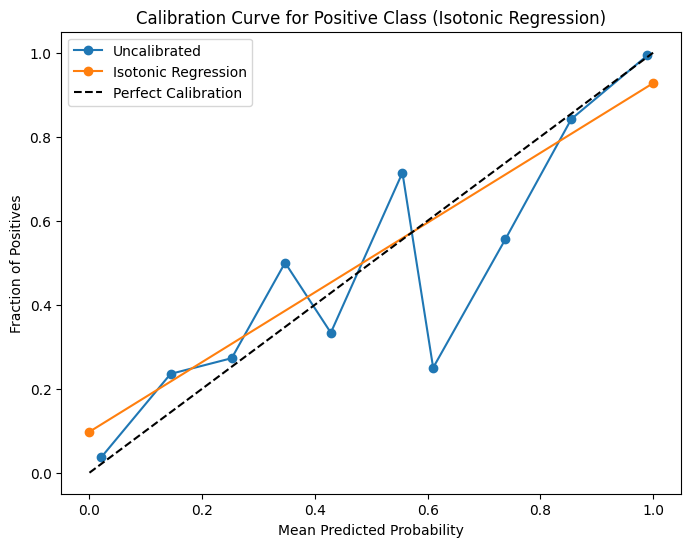

In [ ]:
# Assuming `softmax_probs` are already probabilities in [0, 1] (logits transformed by softmax)
positive_class_idx = 1  # Define the positive class index
positive_probs = softmax_probs[:, positive_class_idx]  # Extract positive class probabilities
positive_labels = (true_labels == positive_class_idx).astype(int)  # Binary labels for the positive class

calibrated_probs_iso = log_reg.predict(positive_probs.reshape(-1,1))

# Plot Calibration Curve
def plot_calibration_curve(y_true, y_prob, n_bins=10, label=None):
    from sklearn.calibration import calibration_curve
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=label)

plt.figure(figsize=(8, 6))

# Uncalibrated
plot_calibration_curve(true_labels, positive_probs, label='Uncalibrated')

# Calibrated
plot_calibration_curve(true_labels, calibrated_probs_iso, label='Isotonic Regression')

# Perfect calibration line
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')

# Plot settings
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve for Positive Class (Isotonic Regression)')
plt.legend()
plt.show()

In [ ]:
import numpy as np

def compute_ece(y_true, y_prob, n_bins=600):
    bins = np.linspace(0, 1, n_bins + 1)  # Define bin edges
    bin_indices = np.digitize(y_prob, bins) - 1  # Assign probabilities to bins

    ece = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        bin_count = np.sum(bin_mask)
        if bin_count > 0:
            bin_confidence = np.mean(y_prob[bin_mask])  # Mean predicted probability
            bin_accuracy = np.mean(y_true[bin_mask])  # Fraction of positives
            ece += (bin_count / len(y_prob)) * np.abs(bin_accuracy - bin_confidence)

    return ece

# Compute ECE for uncalibrated and calibrated models
ece_uncalibrated = compute_ece(true_labels, positive_probs)
ece_calibrated = compute_ece(true_labels, calibrated_probs_iso)

print(f"ECE (Uncalibrated) on Val: {ece_uncalibrated:.4f}")
print(f"ECE (Calibrated): on Val {ece_calibrated:.4f}")


ECE (Uncalibrated) on Val: 0.1018
ECE (Calibrated): on Val 0.0503


In [ ]:
# chceking uncalibrated model on Facebook
softmax_probs = []
true_labels = []
with torch.no_grad():
    for inputs, labels in val_loader_1: #val
        logits = model(inputs)
        probs = F.softmax(logits, dim=1)
        softmax_probs.append(probs.cpu().numpy())
        true_labels.append(labels.cpu().numpy())
softmax_probs = np.concatenate(softmax_probs, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
logits = softmax_probs

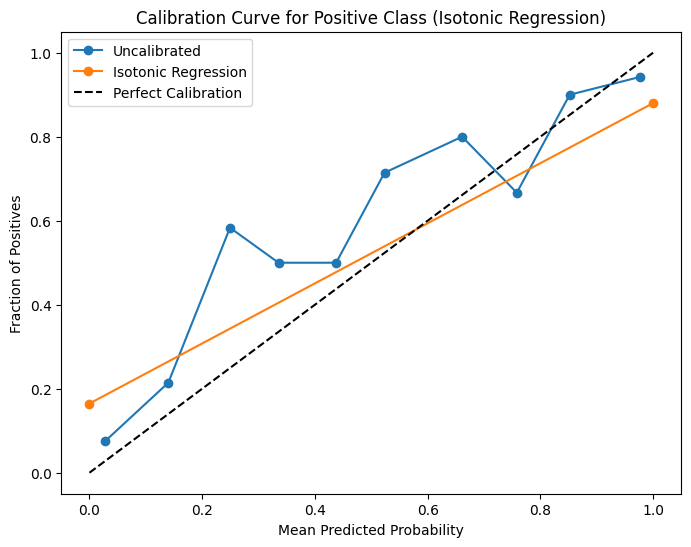

In [ ]:
# Assuming `softmax_probs` are already probabilities in [0, 1] (logits transformed by softmax)
positive_class_idx = 1  # Define the positive class index
positive_probs = softmax_probs[:, positive_class_idx]  # Extract positive class probabilities
positive_labels = (true_labels == positive_class_idx).astype(int)  # Binary labels for the positive class

calibrated_probs_iso = log_reg.predict(positive_probs.reshape(-1,1))

# Plot Calibration Curve
def plot_calibration_curve(y_true, y_prob, n_bins=10, label=None):
    from sklearn.calibration import calibration_curve
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=label)

plt.figure(figsize=(8, 6))

# Uncalibrated
plot_calibration_curve(true_labels, positive_probs, label='Uncalibrated')

# Calibrated
plot_calibration_curve(true_labels, calibrated_probs_iso, label='Isotonic Regression')

# Perfect calibration line
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')

# Plot settings
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve for Positive Class (Isotonic Regression)')
plt.legend()
plt.show()